# Win Predict

## Autor

Erick Melo Vidal de Olvieira - 190027355

## Objetivo

Este modelo tem como objetivo prevera posição que um jogador ficaria em uma partida do jogo PUBG dependendo do que ele faz durante a partida, utilizando para isso a competição [PUBG Finish Placement Prediction (Kernels Only)](https://www.kaggle.com/competitions/pubg-finish-placement-prediction).


## Importando o DataSet

Originalmente o dataset possui mais de 4 milões de linhas, e isso estava causando muita lentidão no treinamento do modelo. Portanto, eu selecionei apenas as 200 mil linhas para reduzir esse atraso.

In [37]:
# Importar as bibliotecas necessárias
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

path = Path('../input/pubg-finish-placement-prediction')

df = pd.read_csv(path/'train_V2.csv').iloc[:200000,:]
test_df = pd.read_csv(path/'test_V2.csv')
df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,8a03aca8bca167,71ff27619423a3,40c91483da5bb9,0,0,0.00,0,0,0,68,...,0,0.0000,0,0.00,0,0,1531.00,7,0,0.4000
199996,982176c1463624,d334f56b3a33be,cfc5059075d4ff,0,0,34.36,0,0,0,82,...,0,0.0000,0,0.00,0,0,11.68,1,0,0.0778
199997,7f55e229133735,b4c4099f227e4d,de2f69ee694142,0,2,327.90,0,1,0,5,...,0,2482.0000,0,0.00,0,0,3065.00,8,0,0.9891
199998,bb6519ba90106c,a8712a3317b739,455a0249beebf8,0,2,311.50,3,1,1,10,...,0,3636.0000,0,0.00,0,0,1187.00,5,0,0.7407


A variável que desejamos prever é a `winPlacePerc`, que varia entre 0 e 1, de modo que 0 significa que o player ficaria em último lugar e 1 significa que ficaria em primeiro. O significado de cada uma das demais colunas pode ser consultado [aqui](https://www.kaggle.com/competitions/pubg-finish-placement-prediction/data)

In [38]:
df.describe(include=(np.number))

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.232945,1.112545,130.764752,0.655985,0.22603,1.367785,47.645770,506.908240,0.925240,0.543795,...,0.163080,601.942806,0.003605,4.545029,0.023500,0.007455,1155.736676,3.672375,609.192020,0.472568
std,0.590604,1.723584,171.826055,1.148558,0.59966,2.667927,27.471291,627.521631,1.564654,0.712604,...,0.466118,1483.874136,0.076825,30.746094,0.165553,0.089663,1184.376026,2.472826,740.250459,0.307548
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,24.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,155.400000,2.000000,0.000000,0.200000
50%,0.000000,0.000000,84.000000,0.000000,0.00000,0.000000,48.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,689.150000,3.000000,0.000000,0.458300
75%,0.000000,2.000000,185.500000,1.000000,0.00000,2.000000,71.000000,1172.000000,1.000000,1.000000,...,0.000000,0.034725,0.000000,0.000000,0.000000,0.000000,1978.000000,5.000000,1495.000000,0.740700
max,21.000000,21.000000,5479.000000,32.000000,40.00000,52.000000,100.000000,2152.000000,48.000000,14.000000,...,16.000000,28450.000000,8.000000,2295.000000,5.000000,4.000000,13530.000000,72.000000,1972.000000,1.000000


Em seguida, eu irei criar uma variável retirando as variáveis que não serão utilizadas para o treinamento do modelo, que são os Ids e a variável que desejamos prever.

In [39]:
X = df.drop(columns=['winPlacePerc', 'Id', 'groupId', 'matchId'])

In [41]:
categorical_columns = df.select_dtypes(include='object')
categorical_columns

,Id,groupId,matchId,matchType
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,squad-fpp
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,squad-fpp
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,duo
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,squad-fpp
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,solo-fpp
...,...,...,...,...
199995,8a03aca8bca167,71ff27619423a3,40c91483da5bb9,squad-fpp
199996,982176c1463624,d334f56b3a33be,cfc5059075d4ff,solo-fpp
199997,7f55e229133735,b4c4099f227e4d,de2f69ee694142,solo-fpp
199998,bb6519ba90106c,a8712a3317b739,455a0249beebf8,squad


Na tabela acima é possível observar que a única coluna categórica que existe no dataset que não seja uma coluna de Ids é a `matchType`, então precisamos realizar o tratamento apenas para ela.

Para isso, usaremos o método `Categorical()` do pandas, que faz com que essa coluna seja tratada como categórica, ou seja, utilizando a função `head()` nesta coluna será exibido o nome de cada categoria, porém, quando o modelo for treinado, ela será vista como números correspondentes a cada categoria.

In [42]:
def proc_data(df):
    df['matchType'] = pd.Categorical(df.matchType)
    
proc_data(df)
proc_data(test_df)

Agora irei separar quais são as variáveis categóricas, contáveis e a variável dependente.

In [43]:
cats = ['matchType']
conts= X.drop(columns='matchType').columns.tolist()
dep="winPlacePerc"

Aqui está um exemplo de como a coluna é vista utilizando a função `head()`

In [44]:
df.matchType.head()

0    squad-fpp
1    squad-fpp
2          duo
3    squad-fpp
4     solo-fpp
Name: matchType, dtype: category
Categories (16, object): ['crashfpp', 'crashtpp', 'duo', 'duo-fpp', ..., 'solo', 'solo-fpp', 'squad', 'squad-fpp']

E aqui como ela será vista pelo modelo

In [81]:
df.matchType.cat.codes.head()

0    15
1    15
2     2
3    15
4    13
dtype: int8

## Analisando os dados

Para realizar a análise dos dados vamos verificar como se comporta a taxa de vitória em cada uma das categorias da coluna matchType.

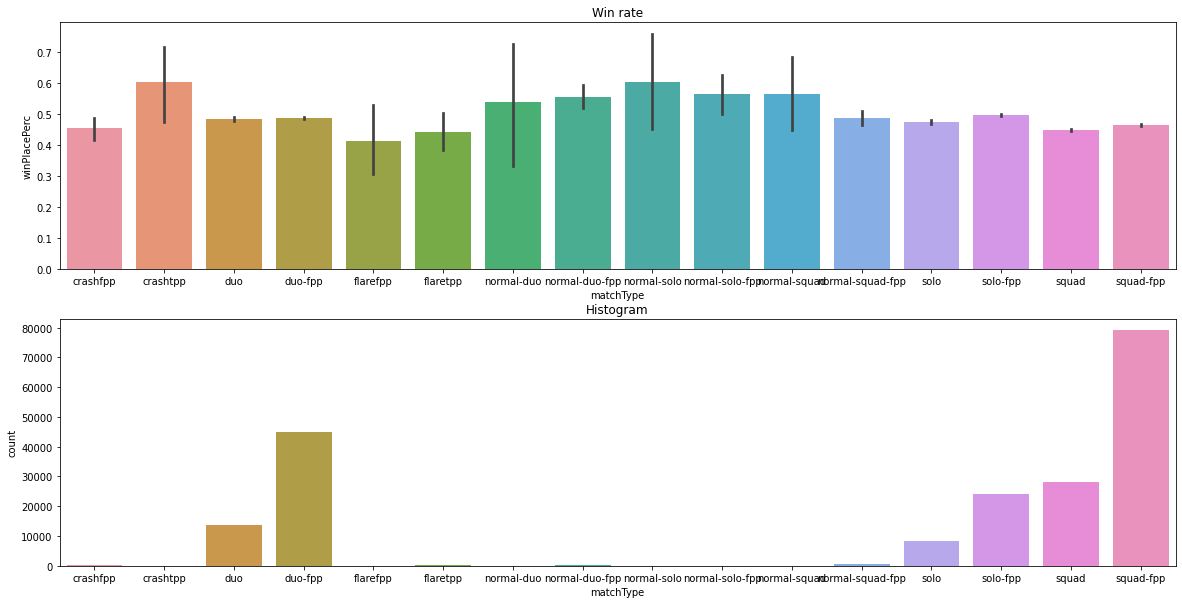

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(2,1, figsize=(20,10))
sns.barplot(data=df, y=dep, x="matchType", ax=axs[0]).set(title="Win rate")
sns.countplot(data=df, x="matchType", ax=axs[1]).set(title="Histogram");

No primeiro gráfico, é possível notar que a maior taxa de vitória está em partidas jogadas no modo normal-solo e no modo crash em terceira pessoa.

Quando é usada a função sns.barplot (do pacote seaborn) para criar um gráfico de barras, o traço preto no meio de cada coluna é chamado de "erro-padrão" ou "intervalo de confiança". Ele mostra o intervalo em que o valor real da média dos dados está com uma determinada confiança.
O erro padrão é uma medida da variação dos dados em relação à média. Quanto menor o erro padrão, menor a variação dos dados e maior a precisão da média.
Já o intervalo de confiança é a faixa de valores dentro da qual o valor real da média estará com uma determinada confiança. Quanto maior o intervalo de confiança, menor a precisão da média.

Já no segundo gráfico, percebe-se que a maior amostra de dados se concentra em partidas do modo esquadrão em primeira pessoa.

## Tratamento dos dados

A seguir, irei dividir o dataframe em dois novos dataframes: "trn_df" e "val_df" usando a função `train_test_split()` do scikit-learn. Esta função divide os dados em um conjunto de treinamento e um conjunto de validação. O parâmetro "test_size" é usado para especificar a proporção dos dados que serão alocados para o conjunto de validação, no caso 0.25 (ou seja, 25%).

Em seguida, o código está aplicando uma função lambda para as colunas especificadas em "cats" (que deve ser uma lista de colunas categóricas) em ambos os dataframes (trn_df e val_df). Essa função lambda está usando o método cat.codes do pandas, que atribui um código numérico inteiro para cada valor único (categoria) na coluna. Esse código inteiro é usado para representar a categoria e é mais eficiente em termos de memória e desempenho do que armazenar as strings da categoria.

In [47]:
from sklearn.model_selection import train_test_split

trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

Agora iremos dividir os dados de treino e de validação definindo uma função que cria uma cópia da sub-tabela das colunas especificadas em "cats" e "conts" do dataframe original e armazena-a na variável "xs".

Em seguida, a função verifica se a coluna "dep" (que é a coluna dependente ou alvo) está presente no dataframe e, se estiver, retorna essa coluna como o segundo elemento da tupla. Caso contrário, a função retorna None.

Depois, a função é chamada duas vezes, uma vez para o dataframe de treinamento (trn_df) e outra vez para o dataframe de validação (val_df) e os resultados são armazenados nas variáveis trn_xs, trn_y, val_xs, e val_y.

In [48]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

## Divisão binária

A divisão binária é um processo utilizado para dividir o espaço de características em sub-espaços menores, com o objetivo de maximizar a separação entre as classes ou valores alvos. Essa divisão é chamada "binária" porque ela é feita de forma recursiva, dividindo o espaço de características em sub-espaços cada vez menores, até que sejam encontrados sub-espaços "puros" de um determinado valor alvo.

Durante a divisão, o algoritmo testa todas as características e seus possíveis valores de corte (como valores médios entre duas observações consecutivas) para encontrar a combinação que melhor separa os dados. Uma vez encontrado o melhor ponto de corte, o espaço de características é dividido em dois sub-espaços e o processo é repetido recursivamente para cada sub-espaço. Esse processo é repetido até que sejam alcançadas as condições de parada especificadas, como atingir o número máximo de nós ou a profundidade máxima da árvore.

Ao final da divisão binária, cada nó da árvore representa um sub-espaço de características e cada folha representa uma previsão para o valor alvo.

Além de maximizar a separação entre as classes, a divisão binária também ajuda a evitar overfitting, pois limita o número de nós e folhas na árvore.

Desse modo, criaremos uma função que calculando a desvio padrão dos valores de y selecionados pela coluna booleana side. O resultado final é multiplicado pela soma de valores boleanos de side, fornecendo assim o score de cada lado da divisão binária. Esse cálculo é comumente utilizado para avaliar a variabilidade dos dados, ou seja, o quanto os valores diferem uns dos outros.

In [49]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Além disso, criaremos a função `score()` que será utilizada para calcular uma pontuação de separação para um dado valor de corte "split" e coluna "col" e valor alvo "y". Ela usa o valor de corte para dividir a coluna em dois grupos e calcula o score para cada grupo usando a função `_side_score()` e retorna a média do score dos dois grupos. Esse valor é utilizado para escolher o melhor ponto de corte para cada coluna.

In [50]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

Então, para escolher o melhor ponto de corte para cada coluna, criaremos a função `iscore()` que será utilizada para calcular uma pontuação de separação para um dado valor de corte "split" e coluna "nm" do conjunto de treino trn_xs e trn_y.

Além disso, utilizaremos o método `interact()` para observar como essa divisão é feita no modelo. Quando um modelo de árvore de decisão está construindo uma árvore, ele está procurando a melhor divisão para cada nó da árvore. Esse melhor corte é determinado pela menor pontuação.

Aumentando o valor de split, significa que o modelo estará procurando por um valor mais alto para dividir a coluna, o que pode resultar em uma maior separação entre as classes, mas também pode resultar em menos dados em uma das subdivisões. Isso pode afetar a precisão do modelo.

Por outro lado, diminuindo o valor de split, significa que o modelo estará procurando por um valor mais baixo para dividir a coluna, o que pode resultar em menos separação entre as classes, mas também pode resultar em mais dados em uma das subdivisões. Isso também pode afetar a precisão do modelo.

Em resumo, aumentando ou diminuindo o valor de split afeta a forma como a coluna é dividida e, consequentemente, a precisão do modelo.

In [51]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('assists', 'boosts', 'damageDealt', 'DBNOs', 'headsh…

Para automatizar este processo então, precisaremos selecionar todos os valores únicos da coluna desejada, neste caso, da "matchType".

In [52]:
nm = "matchType"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8)

O código abaixo cria uma lista de pontuações chamada "scores" que armazena o resultado da função "score" para cada valor único presente na coluna "col" com o objetivo de encontrar o melhor split. Ele faz isso iterando sobre a lista "unq" de valores únicos da coluna "col", chamando a função "score" para cada valor e armazenando o resultado. A lista "scores" será então preenchida com os valores de score para cada valor único.

A função "argmin()" é chamada para encontrar o índice do menor valor na lista "scores", que é o ponto de divisão com o menor score. Esse índice é então usado para recuperar o valor de divisão correspondente na lista "unq".

In [53]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

13

Podemos observar então que o valor de divisão que obteve o menor score foi o 13, ou seja, a categoria "solo-fpp".

Em seguida, criaremos um função que faça isso para todo o dataframe a partir de uma coluna passada como parâmetro e retorne o valor de divisão e o score para esse valor.

In [54]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "matchType")

(13, 0.3074380697323239)

Agora basta chamar esta função para todas as colunas do dataframe da seguinte forma

In [55]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'matchType': (13, 0.3074380697323239),
 'assists': (0, 0.29405504034850255),
 'boosts': (0, 0.23653654015357695),
 'damageDealt': (200.0, 0.2809424663102476),
 'DBNOs': (1, 0.29785838249207475),
 'headshotKills': (0, 0.29549757153096295),
 'heals': (0, 0.25602390659540025),
 'killPlace': (66, 0.21622611033069034),
 'killPoints': (1387, 0.3073915164563745),
 'kills': (1, 0.2834017756828836),
 'killStreaks': (0, 0.28444659769297864),
 'longestKill': (20.29, 0.2746425069433675),
 'matchDuration': (1954, 0.30778268947135357),
 'maxPlace': (34, 0.3073737396278456),
 'numGroups': (41, 0.3073682422388545),
 'rankPoints': (1514, 0.30565540043730666),
 'revives': (0, 0.2976109971375636),
 'rideDistance': (0.0, 0.27632384220445483),
 'roadKills': (0, 0.3075575783323109),
 'swimDistance': (0.8348, 0.2980148862469183),
 'teamKills': (0, 0.307670287821636),
 'vehicleDestroys': (0, 0.3068558684884244),
 'walkDistance': (848.1, 0.19242900339372668),
 'weaponsAcquired': (2, 0.24569645308929972),
 'wi

Podemos observar que o menor score foi na coluna "walkDistance", com um valor de divisão de 848.1 e um score de 0.19. Portanto iremos retirar essa coluna e verificar qual seria a próxima coluna adequada para a divisão de cada lado.

In [56]:
cols.remove("walkDistance")
menor =  trn_df.walkDistance<848.1
menor_g,maior_g = trn_df[menor],trn_df[~menor]

In [57]:
{o:min_col(menor_g, o) for o in cols}

{'matchType': (13, 0.19289955655219174),
 'assists': (0, 0.19341368134884918),
 'boosts': (0, 0.1844266967844005),
 'damageDealt': (100.0, 0.1898694763977012),
 'DBNOs': (1, 0.19393393327161967),
 'headshotKills': (0, 0.1929578970827005),
 'heals': (0, 0.1849173693857622),
 'killPlace': (75, 0.1419642381911651),
 'killPoints': (1506, 0.1947642972032044),
 'kills': (0, 0.1896109973912675),
 'killStreaks': (0, 0.1896109973912675),
 'longestKill': (4.822, 0.18916670527804053),
 'matchDuration': (1576, 0.19306606959964023),
 'maxPlace': (45, 0.19294671006126066),
 'numGroups': (44, 0.19288069513037964),
 'rankPoints': (1502, 0.1940984131666943),
 'revives': (0, 0.193142006010216),
 'rideDistance': (123.8, 0.19043248593406947),
 'roadKills': (0, 0.1946058544840364),
 'swimDistance': (1.389, 0.1944936289976535),
 'teamKills': (0, 0.1946864570586557),
 'vehicleDestroys': (0, 0.19467675839611226),
 'weaponsAcquired': (1, 0.17701158563117853),
 'winPoints': (1534, 0.1942957974139458)}

In [58]:
{o:min_col(maior_g, o) for o in cols}

{'matchType': (13, 0.18778594692290984),
 'assists': (0, 0.1845110408470751),
 'boosts': (2, 0.16948706835325952),
 'damageDealt': (200.2, 0.18024145927328905),
 'DBNOs': (1, 0.18684037266673195),
 'headshotKills': (0, 0.18501330612468916),
 'heals': (0, 0.1813544958635384),
 'killPlace': (53, 0.15962837224376236),
 'killPoints': (1384, 0.1892212948652021),
 'kills': (1, 0.18016436531928945),
 'killStreaks': (0, 0.18066892919439423),
 'longestKill': (17.11, 0.17923031972046366),
 'matchDuration': (1559, 0.1862368941354747),
 'maxPlace': (37, 0.18692263346564494),
 'numGroups': (40, 0.18688398734344297),
 'rankPoints': (1518, 0.1881384661712985),
 'revives': (0, 0.18781985850754299),
 'rideDistance': (3678.0, 0.18882522923826614),
 'roadKills': (0, 0.1898026368322975),
 'swimDistance': (0.5607, 0.18801801242410937),
 'teamKills': (0, 0.18948341627747697),
 'vehicleDestroys': (0, 0.18974369092979806),
 'weaponsAcquired': (4, 0.18732547670471533),
 'winPoints': (1546, 0.18905485921922266)

Podemos observar que tanto no lado dos valores menores quanto do lado dos valores maiores que o valor de divisão do "walkDistance" (848.1), a melhor coluna para ser utilizada na divisão seria a "killPlace"

## Criando a árvore de decisão


Após essa demostração de como é feita a divisão binária, podemos criar o modelo utilizando o método `DecisionTreeRegressor()` passando como parâmetro o `max_leaf_nodes=4`, para que seja criado no máximo apenas 4 folhas. 

In [59]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

m = DecisionTreeRegressor(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [60]:
import graphviz
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

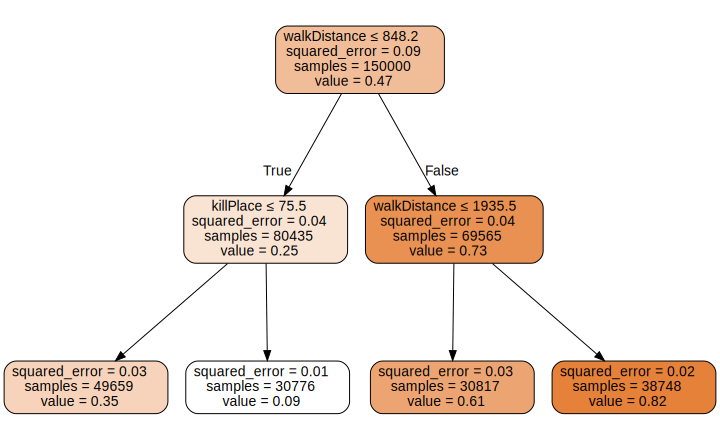

In [61]:
draw_tree(m, trn_xs, size=10)

Como podemos observar, a decisão de split da árvore gerada pelo DecisionTreeRegressor seguiu os mesmos parâmetros observados anteriormente, ou seja, "walkDistance" e "killPlace".

Porém, em uma árvore de desisão existe o índice Gini, que é um índice de impureza usado para medir a qualidade de uma divisão de dados. Ele é baseado na probabilidade de classificar incorretamente um elemento de um conjunto de dados, sendo que quanto menor o índice Gini, melhor a qualidade da divisão.

O cálculo do índice de Gini é feito calculando a probabilidade de um elemento ser classificado incorretamente, caso ele seja sorteado aleatoriamente de um conjunto de dados. Isso é feito somando a probabilidade de cada classe, multiplicada pela probabilidade de escolher incorretamente essa classe.

O cálculo é dado por Gini = 1 - Σ(p_i)^2, onde p_i é a probabilidade de escolher uma classe i.

Em resumo, o Gini é usado para medir a impureza de um conjunto de dados, quanto menor o valor de Gini, menor a impureza e melhor a qualidade da divisão dos dados.

Então, a seguir faremos uma função para calcular esse gini.

In [62]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

Então, para a primeira divisão, esses serão os níveis de impuresa de cada lado da divisão

In [63]:
gini(df.walkDistance<848.1), gini(df.walkDistance>848.1)

(0.37322063837753905, 0.3949802578011188)

Utilizando o método `mean_absolute_error()` podemos notar então que para esse modelo temos um error rate menor que 12%

In [64]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, m.predict(val_xs))

0.11846769603303008

Então, tentaremos verificar se for feito um aumento no número de árvores esse erro irá reduzir. Para isso irei passar para `o DecisionTreeRegressor()` o argumento min_samples_leaf=10000, para que a árvore só pare quando a amostra da divisão for maior que 10000.

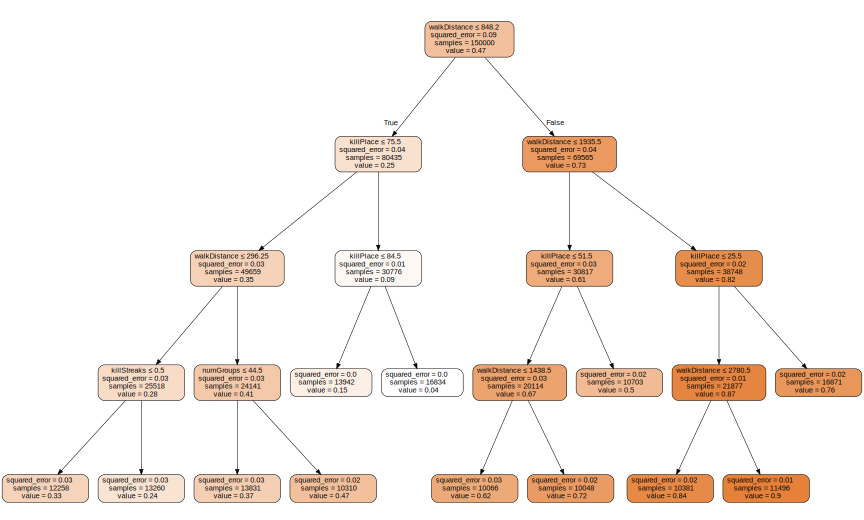

In [65]:
m = DecisionTreeRegressor(min_samples_leaf=10000)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

Calculando o error rate novamente podemos observar que ele caiu para 9.9%

In [66]:
mean_absolute_error(val_y, m.predict(val_xs))

0.09999817992004675

# Random Forest

Random Forest é um algoritmo composto por várias árvores de decisão. Ele funciona criando várias árvores de decisão treinadas de forma independente e depois combinando suas previsões para produzir uma previsão final.

Cada árvore de decisão é treinada utilizando uma amostra aleatória dos dados de treinamento e uma amostra aleatória de características. Isso significa que cada árvore de decisão tem uma visão diferente dos dados e, portanto, pode identificar diferentes padrões e tendências. Ao combinar as previsões dessas árvores, a floresta aleatória é capaz de reduzir a variação e aumentar a precisão.

No código abaixo, iremos criar a função que cria essas árvores, utilizando como padrão 75% dos dados de treinamento e depois chamá-la 100 vezes.

In [67]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeRegressor(min_samples_leaf=10000).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [68]:
trees = [get_tree() for t in range(100)]

No código abaixo, a variável "all_probs" é calculada chamando o método predict em cada um dos 100 modelos de árvore de decisão na lista "trees" usando o conjunto de dados de validação "val_xs" como entrada. Isso nos dará uma lista de 100 arrays, onde cada array contém as previsões de uma das árvores para todos os dados de validação.

Já a variável "avg_probs" será a média das previsões de todas as árvores para cada ponto de dados. Isso é feito usando a função numpy stack para combinar todas as 100 arrays em um único array e, em seguida, fazendo a média dos valores ao longo do eixo 0 (que corresponde às diferentes árvores). Isso nos dá as previsões médias do modelo de floresta aleatória inteira para cada ponto de dados no conjunto de dados de validação.

Então, por último calcularemos o error rate novamente, obtendo um valor de 10.25%

In [69]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.10257663795421147

Para comparar com o modelo que o prórpio sklearn possui, podemos criá-lo utilizando o método `RandomForestRegressor()`

In [70]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(100, min_samples_leaf=10000)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.108787428100985

Podemos observar que o error rate foi de 10.87%, apenas 0.62% pior do que o modelo criado anteriormente.

No gráfico abaixo podemos observar o quão cada coluna do dataset influencia no resultado da coluna que queremos prever, a "winPlacePerc".

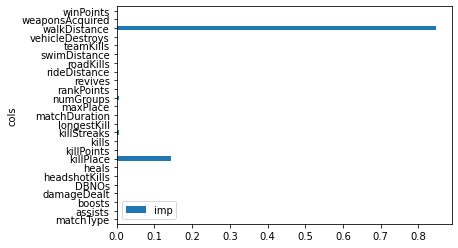

In [71]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

## Deploy do modelo

In [72]:
import pickle

# Carregar o modelo treinado
with open("model.pkl", "wb") as f:
    pickle.dump(m, f)

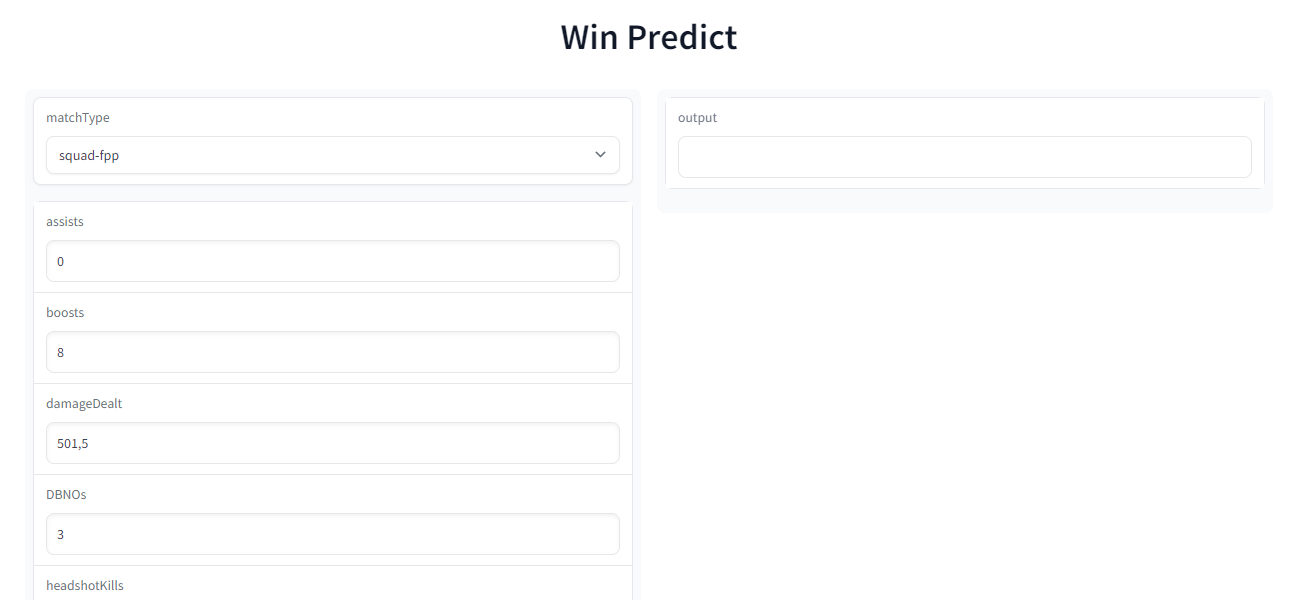

O modelo acima foi carregado no hugging face e pode ser acessado no seguinte link https://huggingface.co/spaces/ErickMVdO/Lesson6